In [1]:
from typing import Sequence

import torch
import copy
import os
import pickle

from torchcast.state_space import Predictions
from torchcast.exp_smooth import ExpSmoother
from torchcast.utils.data import TimeSeriesDataset, TimeSeriesDataLoader

from matplotlib import pyplot as plt
from plotnine import facet_wrap

from tqdm.auto import tqdm

import numpy as np
import pandas as pd

# Using NN's for Long-Range Forecasts: Electricity Data

In this example we'll show how to handle complex series. The domain here is electricity-usage data (using a dataset from the [UCI Machine Learning Data Repository](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014)), and it's a great example of a challenge for traditional forecasting applications. In these traditional approaches, we divide our model into siloed processes that each contribute to separate behaviors of the time-series. For example:

- Hour-in-day effects
- Day-in-week effects
- Season-in-year effects
- Weather effects

However, with electricity data, it's limiting to model these separately, because **these effects all interact**: the impact of hour-in-day depends on the day-of-week, the impact of the day-of-week depends on the season of the year, etc.

In [2]:
BASE_DIR = 'electricity'
SPLIT_DT = np.datetime64('2013-06-01')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data-Prep

In [3]:
try:
    df_elec = pd.read_csv(os.path.join(BASE_DIR, 'df_electricity.csv.gz'), parse_dates=['time'])
except FileNotFoundError as e:
    print(e)
    import requests
    from zipfile import ZipFile
    from io import BytesIO

    response = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip')

    with ZipFile(BytesIO(response.content)) as f:
        df_raw = pd.read_table(f.open('LD2011_2014.txt'), sep=";", decimal=",")
    df_raw['dt'] = df_raw.pop('Unnamed: 0').astype('datetime64[ns]')

    # melt from wide -> long; aggregate from every-15min to every hour
    df_elec = (df_raw
               .melt(id_vars=['dt'], value_name='kW', var_name='group')
               .assign(time=lambda df_elec: df_elec['dt'].dt.to_period('h').dt.to_timestamp())
               .groupby(['group', 'time'])
               ['kW'].mean()
               .reset_index())

    # find start time for each group:
    group_starts = df_elec[df_elec['kW'] > 0].groupby('group')['time'].min()

    # filter to start time:
    df_elec = (df_elec
               .loc[df_elec['time'] >= df_elec['group'].map(group_starts), :]
               .reset_index(drop=True))

    # from dataset documentation: "Every year in March time change day (which has only 23 hours)
    # the values between 1:00 am and 2:00 am are zero for all points"
    zero_counts = df_elec.loc[df_elec['kW'] == 0,'time'].value_counts()
    df_elec.loc[df_elec['time'].isin(zero_counts.index[zero_counts>100]),'kW'] = float('nan')

    # Some groups have data that isn't really appropriate for modeling -- for example, exhibiting near-zero
    # variation (e.g. MT_003). For some rudimentary cleaning, we'll remove these kinds of regions of flatness.
    # For simplicity we'll just drop buildings that are flat in this way for a non-trivial amount of time.
    df_elec['roll_std'] = df_elec.groupby('group')['kW'].rolling(48).std().reset_index(0, drop=True)
    # set to missing when it's low
    df_elec.loc[df_elec.pop('roll_std') < .25, 'kW'] = float('nan')
    # drop groups with nontrivial amount of missings (for simplicity)
    group_missingness = df_elec.assign(missing=lambda df: df['kW'].isnull()).groupby('group')['missing'].mean()
    df_elec = df_elec.loc[df_elec['group'].map(group_missingness) < .01, :].reset_index(drop=True)

    # We'll split the data at mid-2013. For half the groups, the holdout will be used as validation data; for the other
    # half, it will be used as test data.
    df_elec['_use_holdout_as_test'] = (df_elec['group'].str.replace('MT_', '').astype('int') % 2) == 0
    df_elec['dataset'] = 'train'
    df_elec.loc[(df_elec['time'] >= SPLIT_DT) & df_elec['_use_holdout_as_test'], 'dataset'] = 'test'
    df_elec.loc[(df_elec['time'] >= SPLIT_DT) & ~df_elec.pop('_use_holdout_as_test'), 'dataset'] = 'val'

    # drop groups without enough data:
    df_group_summary = (df_elec
                        .groupby(['group','dataset'])
                        ['time'].agg(['min', 'max'])
                        .reset_index()
                        .assign(history_len=lambda df: (df['max'] - df['min']).dt.days))

    all_groups = set(df_group_summary['group'])
    train_groups = sorted(df_group_summary.query("(dataset=='train') & (history_len >= 365)")['group'])
    df_elec = df_elec.loc[df_elec['group'].isin(train_groups), :].reset_index(drop=True)

    # inconveniently, there is only a single observation in 2015, which leads to annoyances later. just drop that one observation:
    assert (df_elec['time'].dt.year >= 2015).sum() <= df_elec['group'].nunique()
    df_elec = df_elec[df_elec['time'].dt.year < 2015].reset_index(drop=True)

    # save
    df_elec.to_csv(os.path.join(BASE_DIR, "df_electricity.csv.gz"), index=False)

assert df_elec['kW'].isnull().mean() < .001
assert df_elec.groupby('group')['time'].is_monotonic_increasing.all()
df_elec['kW'] = df_elec.groupby('group')['kW'].ffill()

np.random.seed(2024-10-4)
torch.manual_seed(2024-10-4)

Our dataset consists of hourly kW readings for multiple buildings:

In [4]:
df_elec.head()

group                time        kW dataset
0  MT_001 2012-01-01 00:00:00  3.172589   train
1  MT_001 2012-01-01 01:00:00  4.124365   train
2  MT_001 2012-01-01 02:00:00  4.758883   train
3  MT_001 2012-01-01 03:00:00  4.441624   train
4  MT_001 2012-01-01 04:00:00  4.758883   train

Let's pick an example group to focus on, for demonstrative purposes:

In [5]:
example_group = 'MT_358'

<Axes: xlabel='time'>

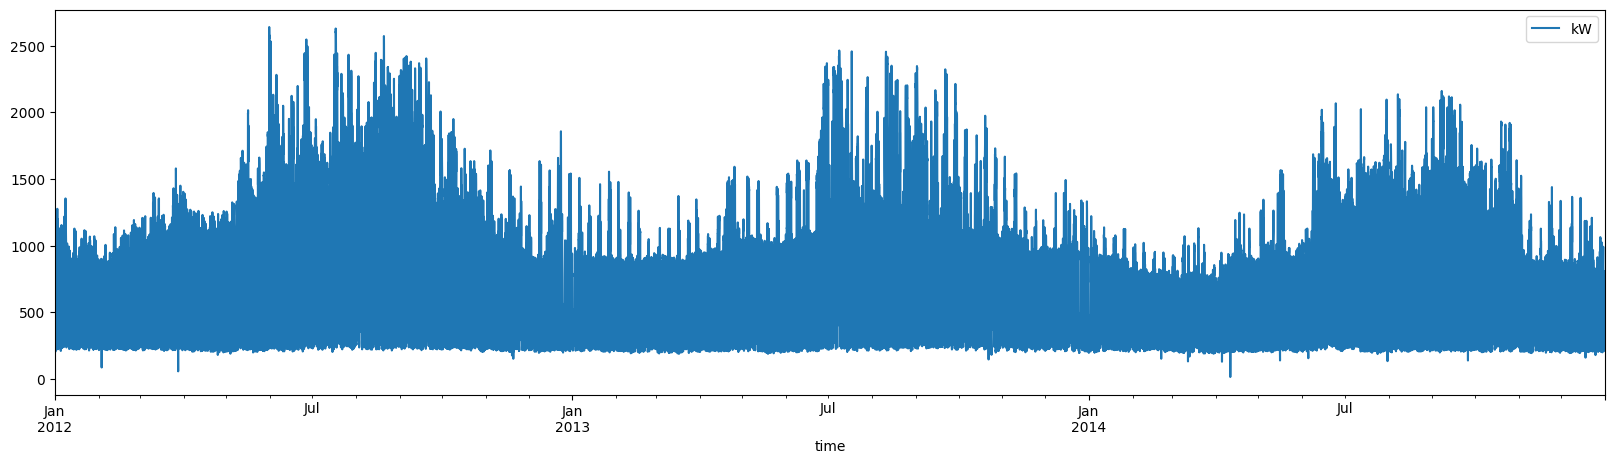

In [6]:
df_elec.query(f"group=='{example_group}'").plot('time', 'kW', figsize=(20, 5))

In [7]:
# we'll apply a sqrt transformation and center before training, and inverse these for plotting/eval:
group_means = (df_elec
               .assign(kW_sqrt = lambda df: np.sqrt(df['kW']))
               .query("dataset=='train'")
               .groupby('group')
               ['kW_sqrt'].mean()
               .to_dict())

def add_transformed(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(kW_sqrt_c = lambda df: np.sqrt(df['kW']) - df['group'].map(group_means))

def add_inv_transformed(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    cols = [c for c in ['lower', 'upper', 'mean', 'actual'] if c in df.columns]
    df[cols] += df['group'].map(group_means).to_numpy()[:, None]
    df[cols] = df[cols].clip(lower=0) ** 2
    if 'measure' in df.columns:
        df['measure'] = df['measure'].str.replace('_sqrt_c', '')
    return df

In [8]:
df_elec = add_transformed(df_elec)

## A Standard Forecasting Approach

### Attempt 1

First, let's try a standard exponential-smoothing algorithm on one of the series.

In [9]:
from torchcast.process import LocalTrend, Season

es = ExpSmoother(
    measures=['kW_sqrt_c'],
    processes=[
        # seasonal processes:
        Season(id='day_in_week', period=24 * 7, dt_unit='h', K=3, fixed=True),
        Season(id='day_in_year', period=24 * 365.25, dt_unit='h', K=8, fixed=True),
        Season(id='hour_in_day', period=24, dt_unit='h', K=8, fixed=True),
        # long-running trend:
        LocalTrend(id='trend'),
    ]
)

In [10]:
ds_example_building = TimeSeriesDataset.from_dataframe(
    df_elec.query("group == @example_group"),
    group_colname='group',
    time_colname='time',
    dt_unit='h',
    measure_colnames=['kW_sqrt_c'],
)
ds_example_train, _ = ds_example_building.train_val_split(dt=SPLIT_DT)
ds_example_train

TimeSeriesDataset(sizes=[torch.Size([1, 12408, 1])], measures=(('kW_sqrt_c',),))

In [11]:
es.fit(
    ds_example_train.tensors[0],
    start_offsets=ds_example_train.start_datetimes,
)

Initializing trend.position to -3.935213044314878e-08


  0%|          | 0/12 [00:00<?, ?it/s]

ExpSmoother(processes=[Season(id='day_in_week'), Season(id='day_in_year'), Season(id='hour_in_day'), LocalTrend(id='trend')], measures=['kW_sqrt_c'])

The problem is that the forecasts are **terrible**:

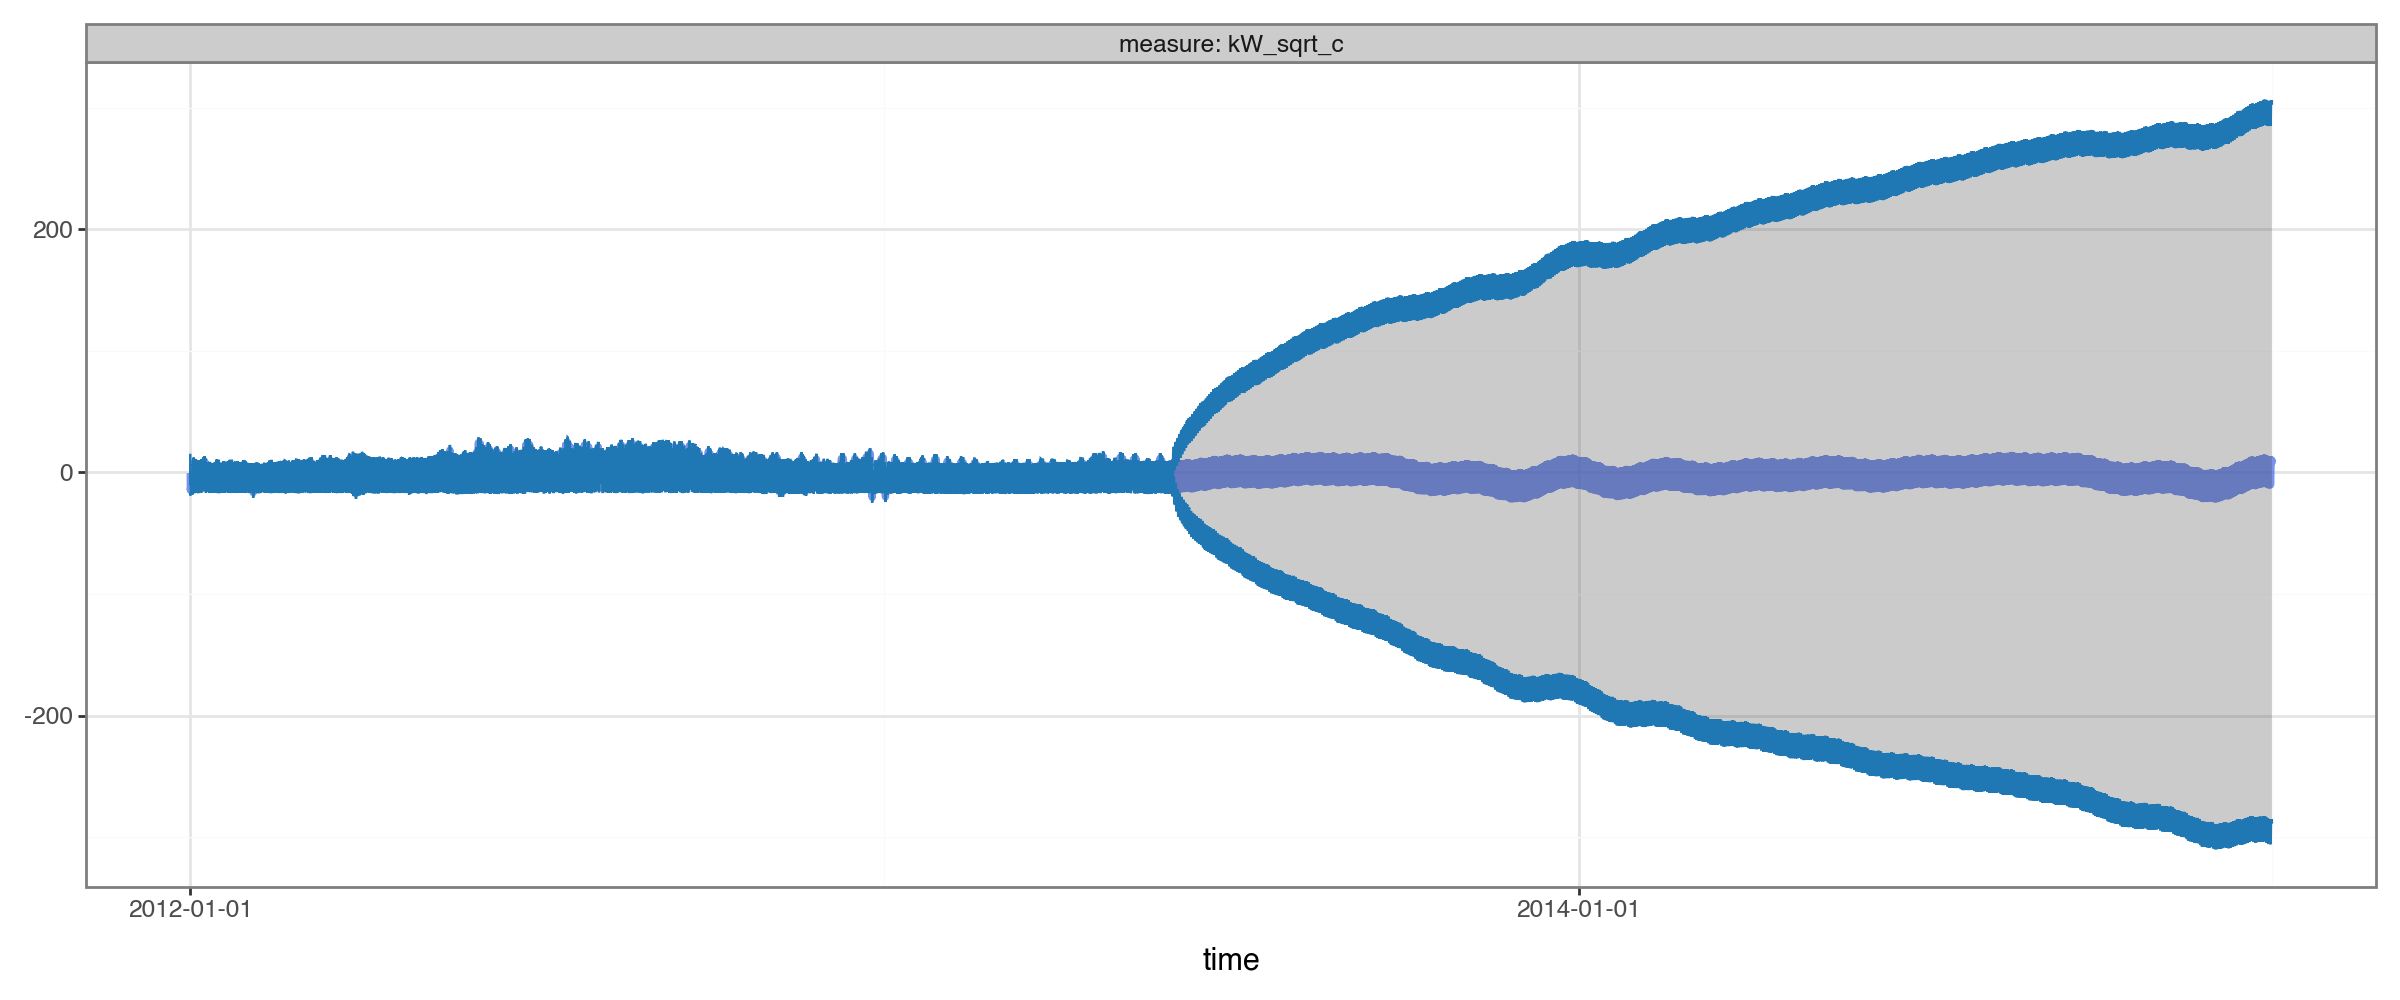

In [12]:
es_predictions = es(
    ds_example_train.tensors[0],
    start_offsets=ds_example_train.start_datetimes,
    # note we *not* getting `num_timesteps` from `ds_example_train`, since we want to forecast outside the training time:
    out_timesteps=ds_example_building.num_timesteps
)
es_predictions.plot()

The most obvious issue here is the discrepancy between the predictions on the training data (which look sane) and the validation data (which look insane). 

This isn't overfitting, but instead the difference between one-step-ahead predictions vs. long-range forecasts.

What's going on here? Part of the problem is that **the model wasn't actually trained to generate long-range forecasts.** The standard approach has us train on one-step-ahead predictions -- here, that means one *hour* ahead predictions.

### Attempt 2

Let's see if we can improve on this. We'll leave the model unchanged, but train it differently. We'll use the `n_step` argument to train our model on one-week ahead forecasts, instead of one-hour ahead. This improves the efficiency of training by encouraging the model to 'care about' longer range forecasts vs. over-focusing on the easier problem of forecasting the next hour.

Another thing we'll address is the fact that the simple (and lousy) model above was surprisingly slow to train. This is because Pytorch has a non-trivial overhead for separate tensors: i.e., it scales well with an increasing batch-size (fewer, but bigger, tensors), but poorly with an increasing time-series length (smaller, but more, tensors). So to speed things up, we'll split our single series into multiple groups.

In [13]:
df_elec['subgroup'] = df_elec['group'] + ':' + df_elec['time'].dt.year.astype('str') + ':' + df_elec['time'].dt.quarter.astype('str')
df_elec.head()

group                time        kW dataset  kW_sqrt_c       subgroup
0  MT_001 2012-01-01 00:00:00  3.172589   train  -0.167036  MT_001:2012:1
1  MT_001 2012-01-01 01:00:00  4.124365   train   0.082642  MT_001:2012:1
2  MT_001 2012-01-01 02:00:00  4.758883   train   0.233275  MT_001:2012:1
3  MT_001 2012-01-01 03:00:00  4.441624   train   0.159304  MT_001:2012:1
4  MT_001 2012-01-01 04:00:00  4.758883   train   0.233275  MT_001:2012:1

In [14]:
ds_example_building2 = TimeSeriesDataset.from_dataframe(
    df_elec.query("group == @example_group"),
    group_colname='subgroup',
    time_colname='time',
    dt_unit='h',
    measure_colnames=['kW_sqrt_c'],
)

ds_example_train2, _ = ds_example_building2.train_val_split(dt=SPLIT_DT, quiet=True)
# our subgroup approach leaves a few of the resulting time-series as very small periods (<60 days) we'd like to drop
ds_example_train2 = ds_example_train2[ds_example_train2.get_durations() > 1400]
ds_example_train2

TimeSeriesDataset(sizes=[torch.Size([6, 2208, 1])], measures=(('kW_sqrt_c',),))

In [15]:
es2 = ExpSmoother(
    measures=['kW_sqrt_c'],
    processes=[
        Season(id='day_in_week', period=24 * 7, dt_unit='h', K=3, fixed=True),
        Season(id='day_in_year', period=24 * 365.25, dt_unit='h', K=8, fixed=True),
        Season(id='hour_in_day', period=24, dt_unit='h', K=8, fixed=True),
        LocalTrend(id='trend'),
    ]
)

es2.fit(
    ds_example_train2.tensors[0],
    start_offsets=ds_example_train2.start_datetimes,
    n_step=int(24 * 7.5),
    every_step=False, # this speeds up training when n_step > 1
)

Initializing trend.position to -3.935213044314878e-08


  0%|          | 0/12 [00:00<?, ?it/s]

ExpSmoother(processes=[Season(id='day_in_week'), Season(id='day_in_year'), Season(id='hour_in_day'), LocalTrend(id='trend')], measures=['kW_sqrt_c'])

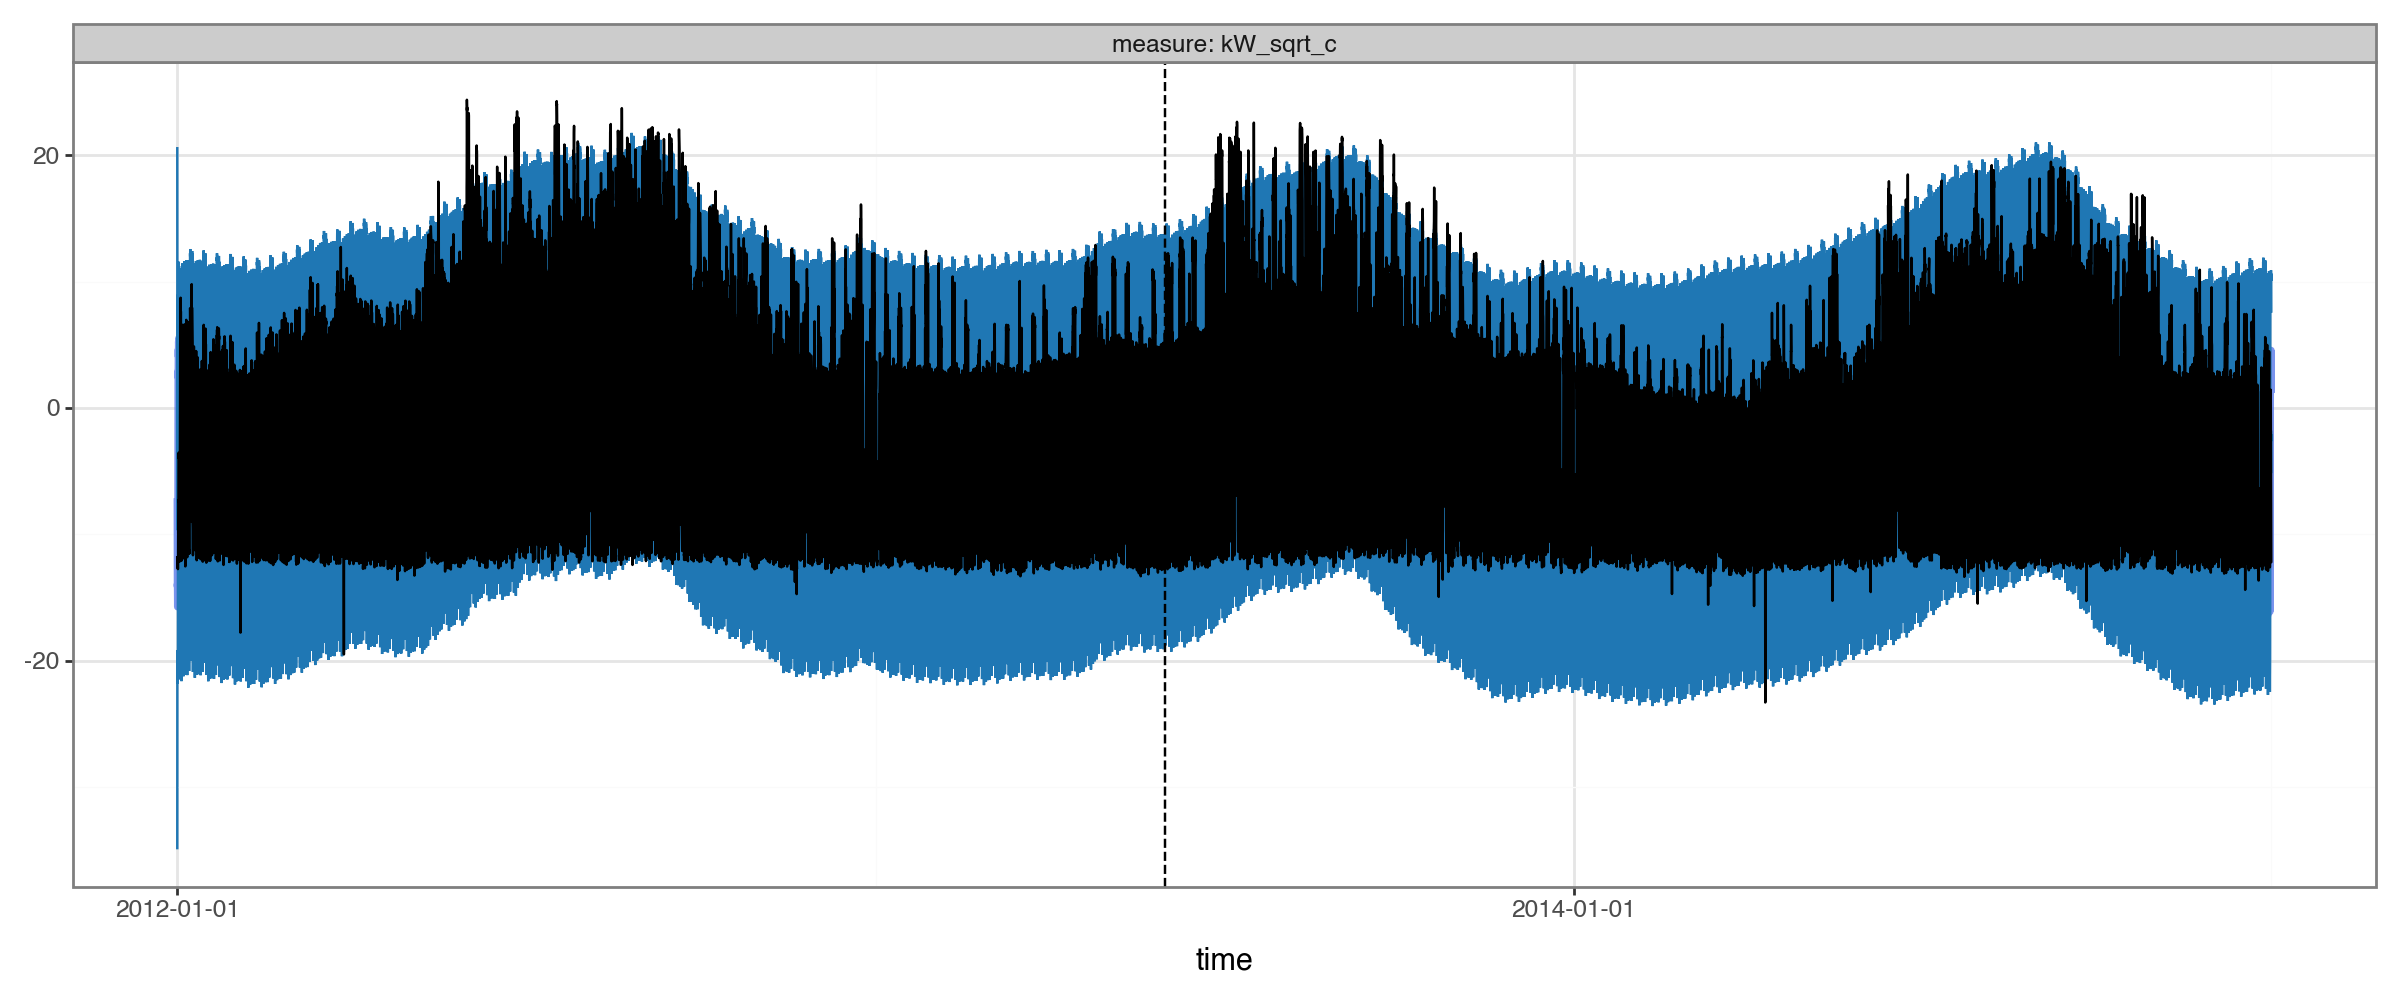

In [17]:
es2_predictions = es2(
    ds_example_train.tensors[0],
    start_offsets=ds_example_train.start_datetimes,
    out_timesteps=ds_example_building.num_timesteps
)
es2_predictions.plot(es2_predictions.to_dataframe(ds_example_building), split_dt=SPLIT_DT)

Seems like a massive improvement... Unfortunately, with hourly data, visualizing long-range forecasts in this way isn't very illuminating: it's just really hard to see the data! 

We can try zooming in:

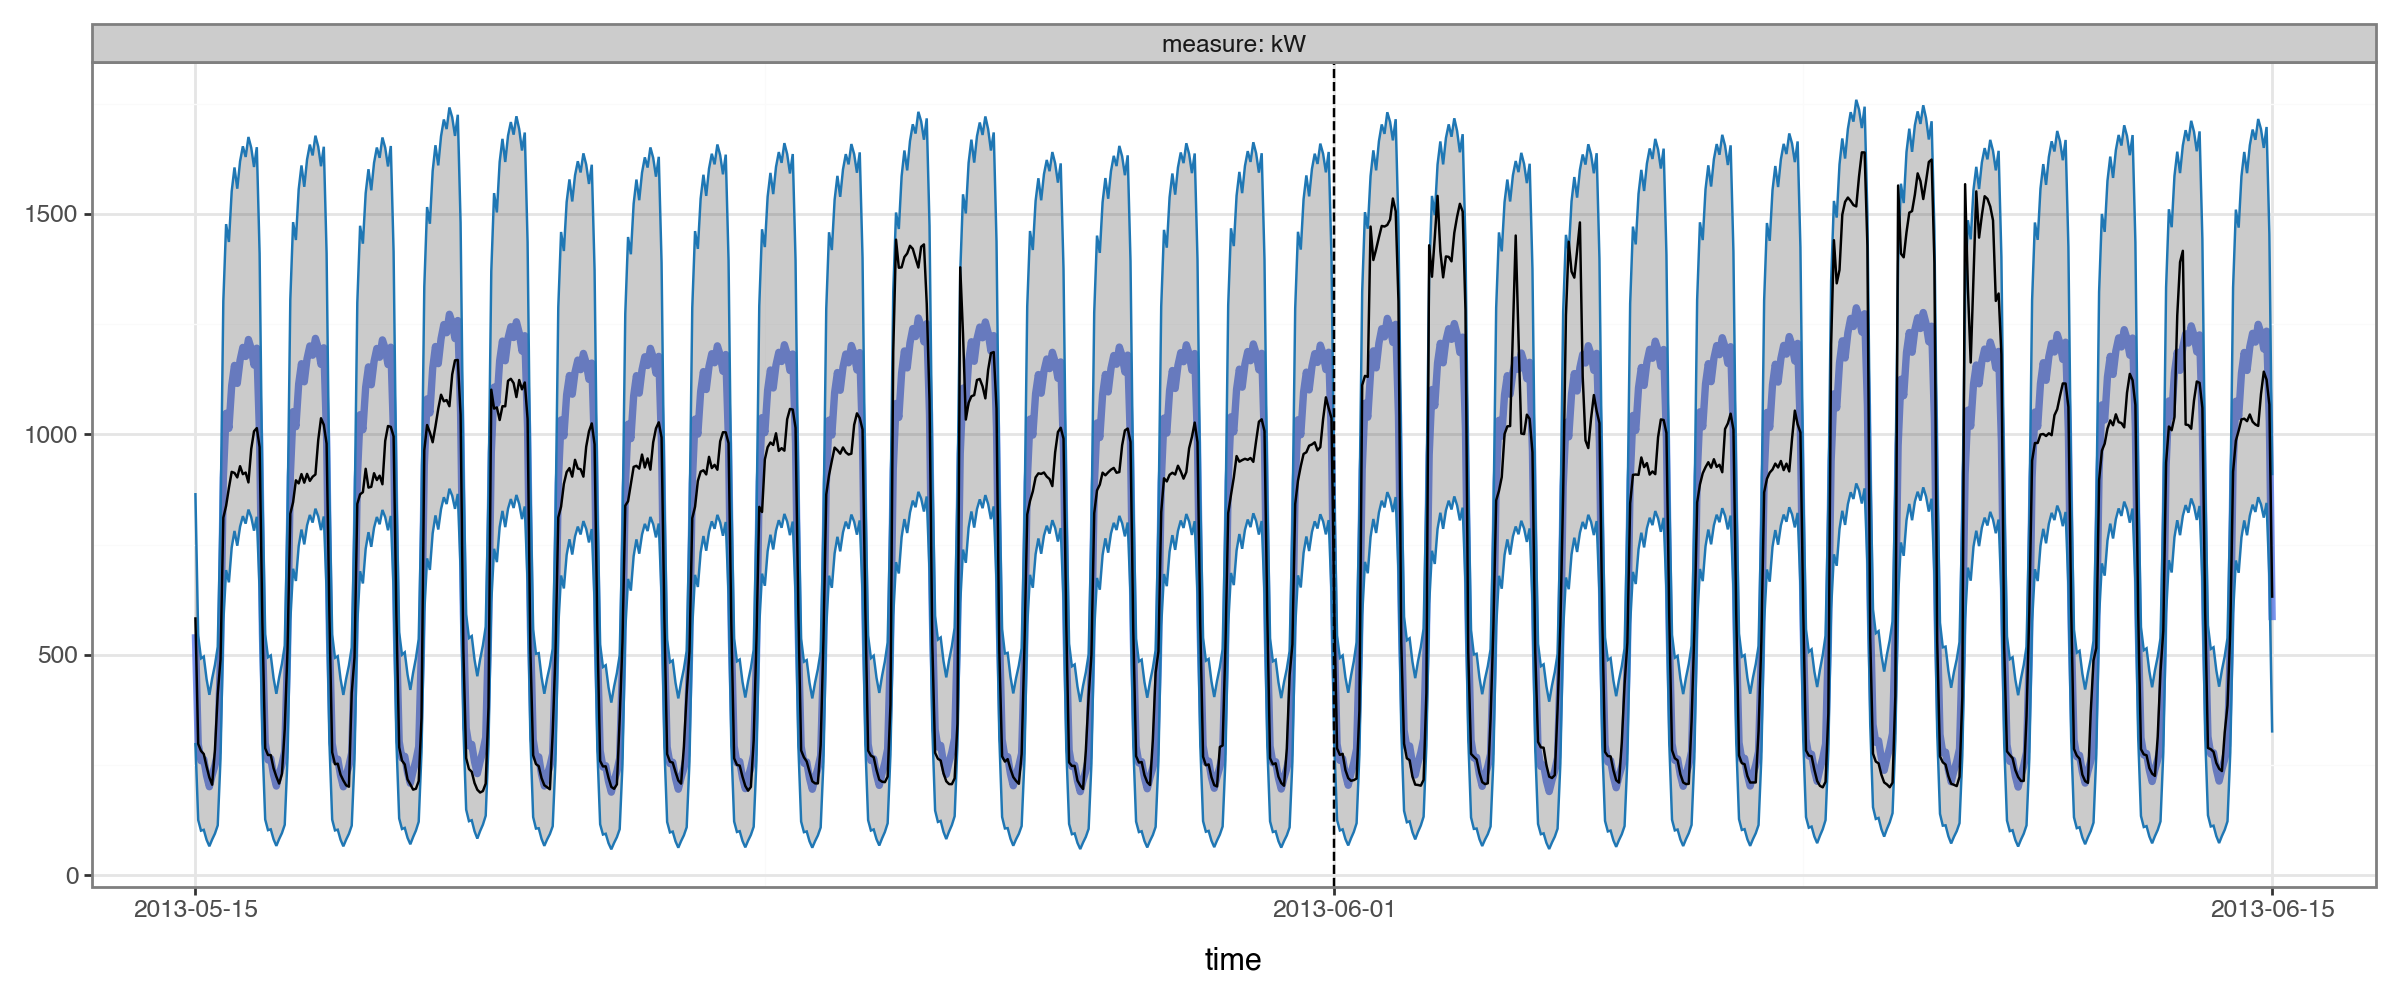

In [18]:
es2_predictions.plot(
    es2_predictions
    .to_dataframe(ds_example_building).query("time.between('2013-05-15', '2013-06-15')")
    .pipe(add_inv_transformed),
    split_dt=SPLIT_DT
)

This is better for actually seeing the data, but ideally we'd still like to get a view of the long range. 

Let's instead try splitting it into weekdays vs. weekends and daytimes vs. nightimes:

In [19]:
def plot_2x2(df: pd.DataFrame, 
             pred_colname: str = 'mean', 
             actual_colname: str = 'actual', 
             group_colname: str = 'group',
             time_colname: str = 'time',
             **kwargs):
    """
    Plot predicted vs. actual for a single group, splitting into 2x2 facets of weekday/end * day/night.
    """
    df_plot = df.assign(
        time_of_day=None, 
        weekend=lambda df: np.where(df[time_colname].dt.weekday.isin([5, 6]), 'weekend', 'weekday'),
        date=lambda df: df[time_colname].dt.normalize()
    )
    df_plot.loc[df_plot[time_colname].dt.hour.isin([14, 15, 16, 17, 18]), 'time_of_day'] = 'day'
    df_plot.loc[df_plot[time_colname].dt.hour.isin([2, 3, 4, 5, 6]), 'time_of_day'] = 'night'
    df_plot[time_colname] = df_plot.pop('date')
    _agg = [pred_colname, actual_colname]
    if 'upper' in df_plot.columns:
        _agg.extend(['upper', 'lower'])
    df_plot = df_plot.groupby([group_colname, time_colname, 'weekend', 'time_of_day'])[_agg].mean().reset_index()
    df_plot['measure'] = df_plot['weekend'] + ' ' + df_plot['time_of_day']
    df_plot['mean'] = df_plot.pop(pred_colname)
    df_plot['actual'] = df_plot.pop(actual_colname)
    if 'upper' not in df_plot.columns:
        df_plot['lower'] = df_plot['upper'] = float('nan')
    return Predictions.plot(df_plot, time_colname=time_colname, group_colname=group_colname, **kwargs) + facet_wrap('measure')

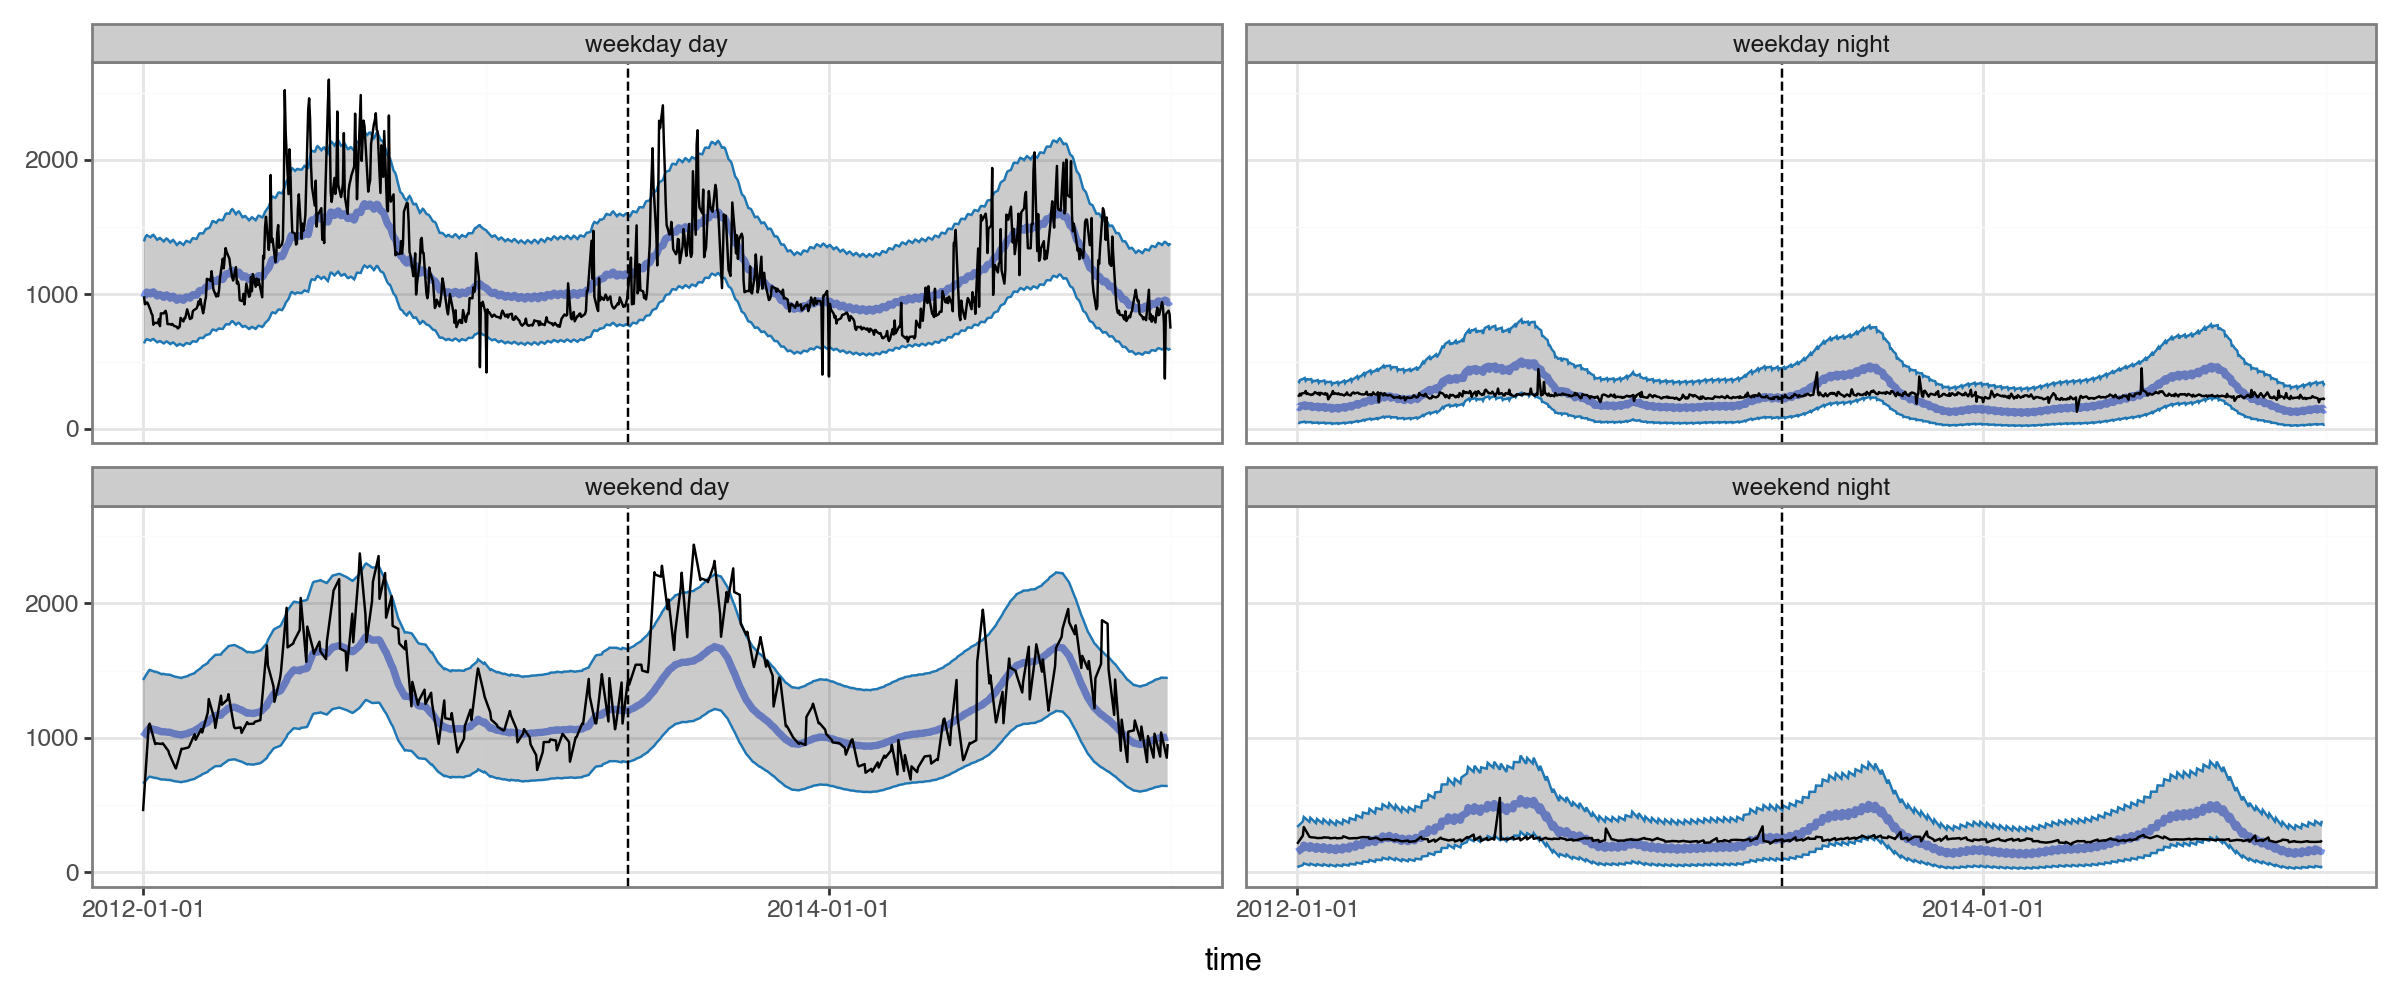

In [20]:
plot_2x2(es2_predictions
         .to_dataframe(ds_example_building)
         .pipe(add_inv_transformed)
         ,split_dt=SPLIT_DT)

Viewing the forecasts in this way helps us see a lingering serious issue: the annual seasonal pattern is very different for daytimes and nighttimes, but the model isn't capturing that at all. (In fact, even the lower amplitude in annual seasonality for nighttime forecasts is just an artifact of our sqrt-transform, not a product of the model.)

The limitation is inherent to the model: it only allows for a single seasonal pattern, rather than a separate one for different times of the day and days of the week. 

## Incorporating a Neural Network

We saw our time-series model wasn't allowing for interactions among the components of our time-series model. A natural solution to this is to incorporate a neural network -- learning arbitrary/complex interactions is exactly what they are for.

Of course, this requires scaling up our dataset: **we want to learn across multiple series, so that our network can build representations of patterns that are shared across multiple buildings.**

### Encoding Seasonlity as Fourier Terms

We're going to need to encode the seasonal cycles in our data into features that a neural-network can use as inputs.

There are multiple ways we can do this. For example, one option would be to extract each component of our datetimes and one-hot encode it:

In [21]:
(df_elec
 .loc[df_elec['group']==example_group,['time']]
 .assign(hod=lambda df: df['time'].dt.hour, dow=lambda df: df['time'].dt.dayofweek)
 .pipe(pd.get_dummies, columns=['hod', 'dow'], dtype='float')
 .head())

time  hod_0  hod_1  hod_2  hod_3  hod_4  hod_5  hod_6  \
9232450 2012-01-01 00:00:00    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
9232451 2012-01-01 01:00:00    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
9232452 2012-01-01 02:00:00    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
9232453 2012-01-01 03:00:00    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
9232454 2012-01-01 04:00:00    0.0    0.0    0.0    0.0    1.0    0.0    0.0   

         hod_7  hod_8  ...  hod_21  hod_22  hod_23  dow_0  dow_1  dow_2  \
9232450    0.0    0.0  ...     0.0     0.0     0.0    0.0    0.0    0.0   
9232451    0.0    0.0  ...     0.0     0.0     0.0    0.0    0.0    0.0   
9232452    0.0    0.0  ...     0.0     0.0     0.0    0.0    0.0    0.0   
9232453    0.0    0.0  ...     0.0     0.0     0.0    0.0    0.0    0.0   
9232454    0.0    0.0  ...     0.0     0.0     0.0    0.0    0.0    0.0   

         dow_3  dow_4  dow_5  dow_6  
9232450    0.0    0.0    0.0    1.0  
9232451    0.0    0.0    0.0    1.0  
9232452    0.0    0.0    0.0    1.0  
9232453    0.0    0.0    0.0    1.0  
9232454    0.0    0.0    0.0    1.0  

[5 rows x 32 columns]

Instead, we'll use a different approach based on **fourier series**. Basically, we encoded our times into sine/cosine waves. The number of waves is a hyper-parameter that can be tuned and helps us control how 'wiggly' we'll allow the seasons to be. For more reading on using fourier series for modeling seasonality, see [here](https://otexts.com/fpp2/useful-predictors.html#fourier-series) and [here](https://otexts.com/fpp2/complexseasonality.html#dynamic-harmonic-regression-with-multiple-seasonal-periods).

For visualization (and shortly, modeling), we'll use `torchcast`'s `add_season_features` function:

In [22]:
from torchcast.utils import add_season_features

df_example = (df_elec[df_elec['group'] == example_group]
              .reset_index(drop=True)
              .pipe(add_season_features, K=8, period='yearly')
              .pipe(add_season_features, K=3, period='weekly')
              .pipe(add_season_features, K=8, period='daily'))

yearly_season_feats = df_example.columns[df_example.columns.str.startswith('yearly_')].tolist()
weekly_season_feats = df_example.columns[df_example.columns.str.startswith('weekly_')].tolist()
daily_season_feats = df_example.columns[df_example.columns.str.startswith('daily_')].tolist()
season_feats = yearly_season_feats + weekly_season_feats + daily_season_feats

Let's visualize these waves:

<Axes: title={'center': 'Daily Fourier Terms'}, xlabel='time'>

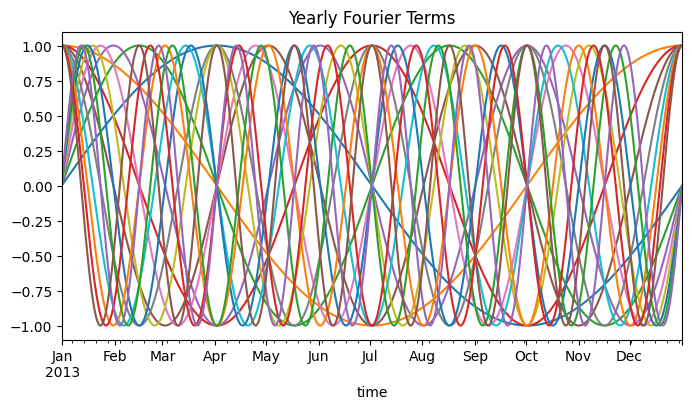

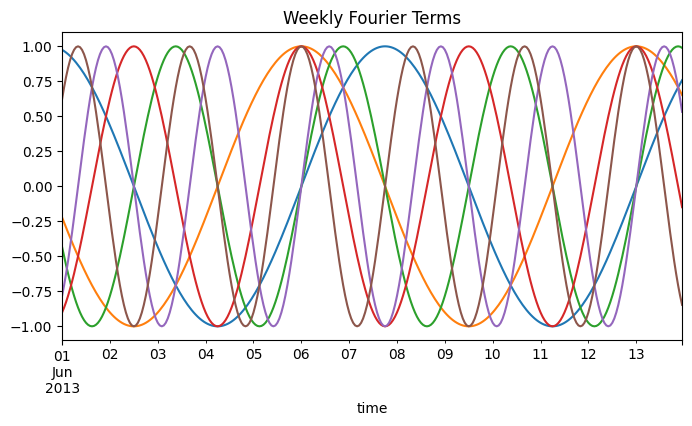

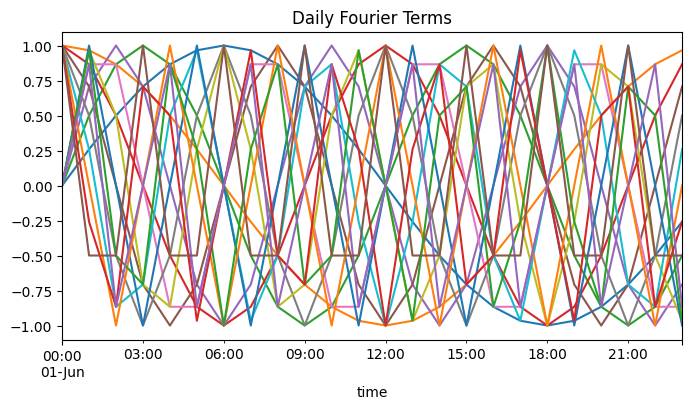

In [23]:
(df_example[yearly_season_feats + ['time']]
 .query("time.dt.year == 2013")
 .plot(x='time', figsize=(8,4), legend=False, title='Yearly Fourier Terms'))

(df_example[weekly_season_feats + ['time']]
 .query("(time.dt.year == 2013) & (time.dt.month == 6) & (time.dt.day < 14)")
 .plot(x='time', figsize=(8,4), legend=False, title='Weekly Fourier Terms'))

(df_example[daily_season_feats + ['time']]
 .query("(time.dt.year == 2013) & (time.dt.month == 6) & (time.dt.day == 1)")
 .plot(x='time', figsize=(8,4), legend=False, title='Daily Fourier Terms'))

### Step 1: Pre-Training a Seasonal-Embeddings NN

For this task, we'll switch from exponential smoothing (with `ExpSmoother`) to a full state-space model (with `KalmanFilter`). This is because only the latter can learn relationships specific to each time-series.

The `LinearModel` provides a catch-all for any way of passing arbitrary inputs to our model. For example, if we had weather data -- temperature, humidity, wind-speed -- we might add a process like:

```
LinearModel(id='weather', predictors=['temp','rhumidity','windspeed'])
```

And our time-series model would learn how each of these impacts our series(es).

Here we are using `LinearModel` a little differently: rather than it taking as input predictors, it will take as input the *output* of a neural-network, which itself will take predictors (the calendar-features we just defined).

What we'd like to do is train a neural network to embed the seasonality (as represented by our fourier terms) into a lower dimensional space, then we'll pass that lower dimensional representation onto our KalmanFilter/LinearModel, which will learn how each time-series behaves in relation to that space. Basically, we are reducing the dozens of calendar-features (and their hundreds of interactions) into an efficient low-dimensional representation.

For this purpose, `torchcast` provides the `SeasonalEmbeddingsTrainer` class:

In [24]:
from torchcast.utils.training import SeasonalEmbeddingsTrainer

SEASON_EMBED_NDIM = 20

season_embedder = torch.nn.Sequential(
    torch.nn.LazyLinear(out_features=48),
    torch.nn.Tanh(),
    torch.nn.Linear(48, 48),
    torch.nn.Tanh(),
    torch.nn.Linear(48, SEASON_EMBED_NDIM)
)

season_trainer = SeasonalEmbeddingsTrainer(
    module=season_embedder,
    yearly=8,
    weekly=3,
    daily=8
)

Again, the number of embedding dimensions is a hyper-parameter, where we trade off computational efficiency for precision.

Since we'll be training on the whole dataset instead of just one example building, we'll switch from a `TimeSeriesDataset` to a `TimeSeriesDataLoader`, which lets us iterate over the whole dataset in a training loop:

In [25]:
season_dl = TimeSeriesDataLoader.from_dataframe(
    df_elec.query("dataset=='train'"),
    group_colname='group',
    time_colname='time',
    dt_unit='h',
    measure_colnames=['kW_sqrt_c'],
    batch_size=45 # fairly even batch sizes
)

Let's use our trainer to train `season_embedder`:

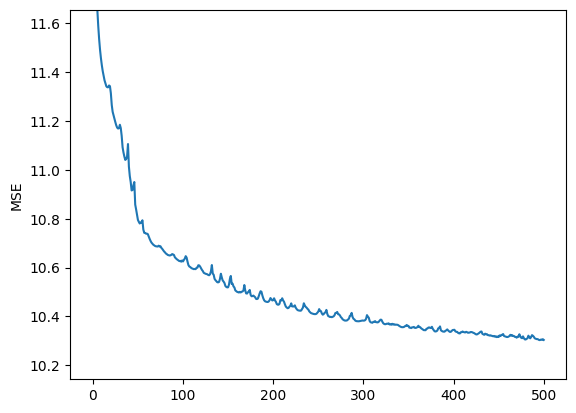

In [26]:
try:
    _path = os.path.join(BASE_DIR, f"season_trainer{SEASON_EMBED_NDIM}.pt")
    with open(_path, 'rb') as f:
        season_trainer = pickle.load(f).to(DEVICE)
    season_embedder = season_trainer.module
    plt.plot(season_trainer.loss_history)
    plt.ylim(None, max(season_trainer.loss_history[5:]))
    plt.ylabel('MSE')
    plt.show()
    
except FileNotFoundError as e:
    from IPython.display import clear_output

    season_trainer.loss_history = []
    for loss in season_trainer(season_dl):
        season_trainer.loss_history.append(loss)

        # plot:
        if len(season_trainer.loss_history) > 5:
            clear_output(wait=True)
            plt.plot(season_trainer.loss_history)
            plt.ylim(None, max(season_trainer.loss_history[5:]))
            plt.ylabel('MSE')
            plt.show()

        if len(season_trainer.loss_history) > 500:
            break

    with open(_path, 'wb') as f:
        pickle.dump(season_trainer, f)

season_trainer.to(torch.device('cpu'))

Let's visualize the output of this neural network, with each color being a separate output:

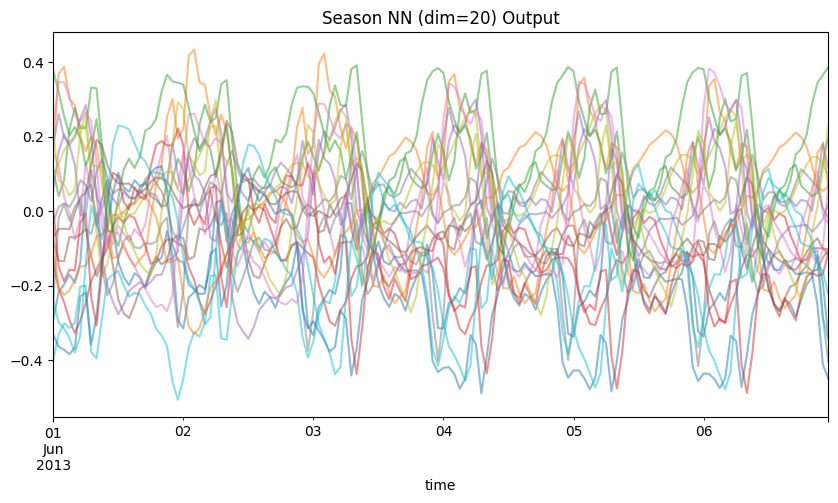

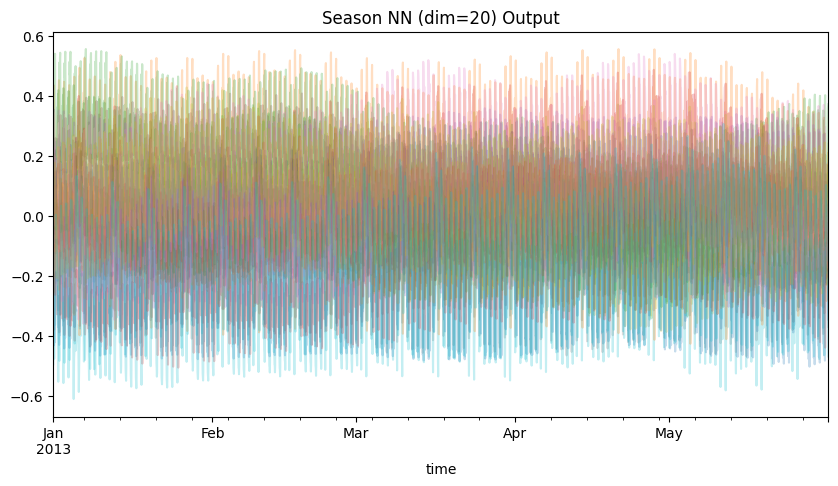

In [27]:
with torch.no_grad():
    times = ds_example_building.times().squeeze()
    pred = season_trainer.module(season_trainer.times_to_model_mat(times).to(torch.float))
    _df_pred = pd.DataFrame(pred.numpy()).assign(time=times)
    
    (_df_pred
         .query("(time.dt.year == 2013) & (time.dt.month == 6) & (time.dt.day < 7)")
         .plot(x='time', figsize=(10,5), legend=False, title=f'Season NN (dim={SEASON_EMBED_NDIM}) Output', alpha=0.5))

    (_df_pred
         .query("(time.dt.year == 2013) & (time.dt.month < 6)")
         .plot(x='time', figsize=(10,5), legend=False, title=f'Season NN (dim={SEASON_EMBED_NDIM}) Output', alpha=0.25))

You can think of each colored line as equivalent to the sin/cos waves above; but now, instead of dozens of these, we have far fewer, that should *hopefully* be able to capture interacting seasonal effects.

Let's verify this. The season-trainer has a `predict` method that lets us visualize how these embeddings can be used to predict the actual series values:

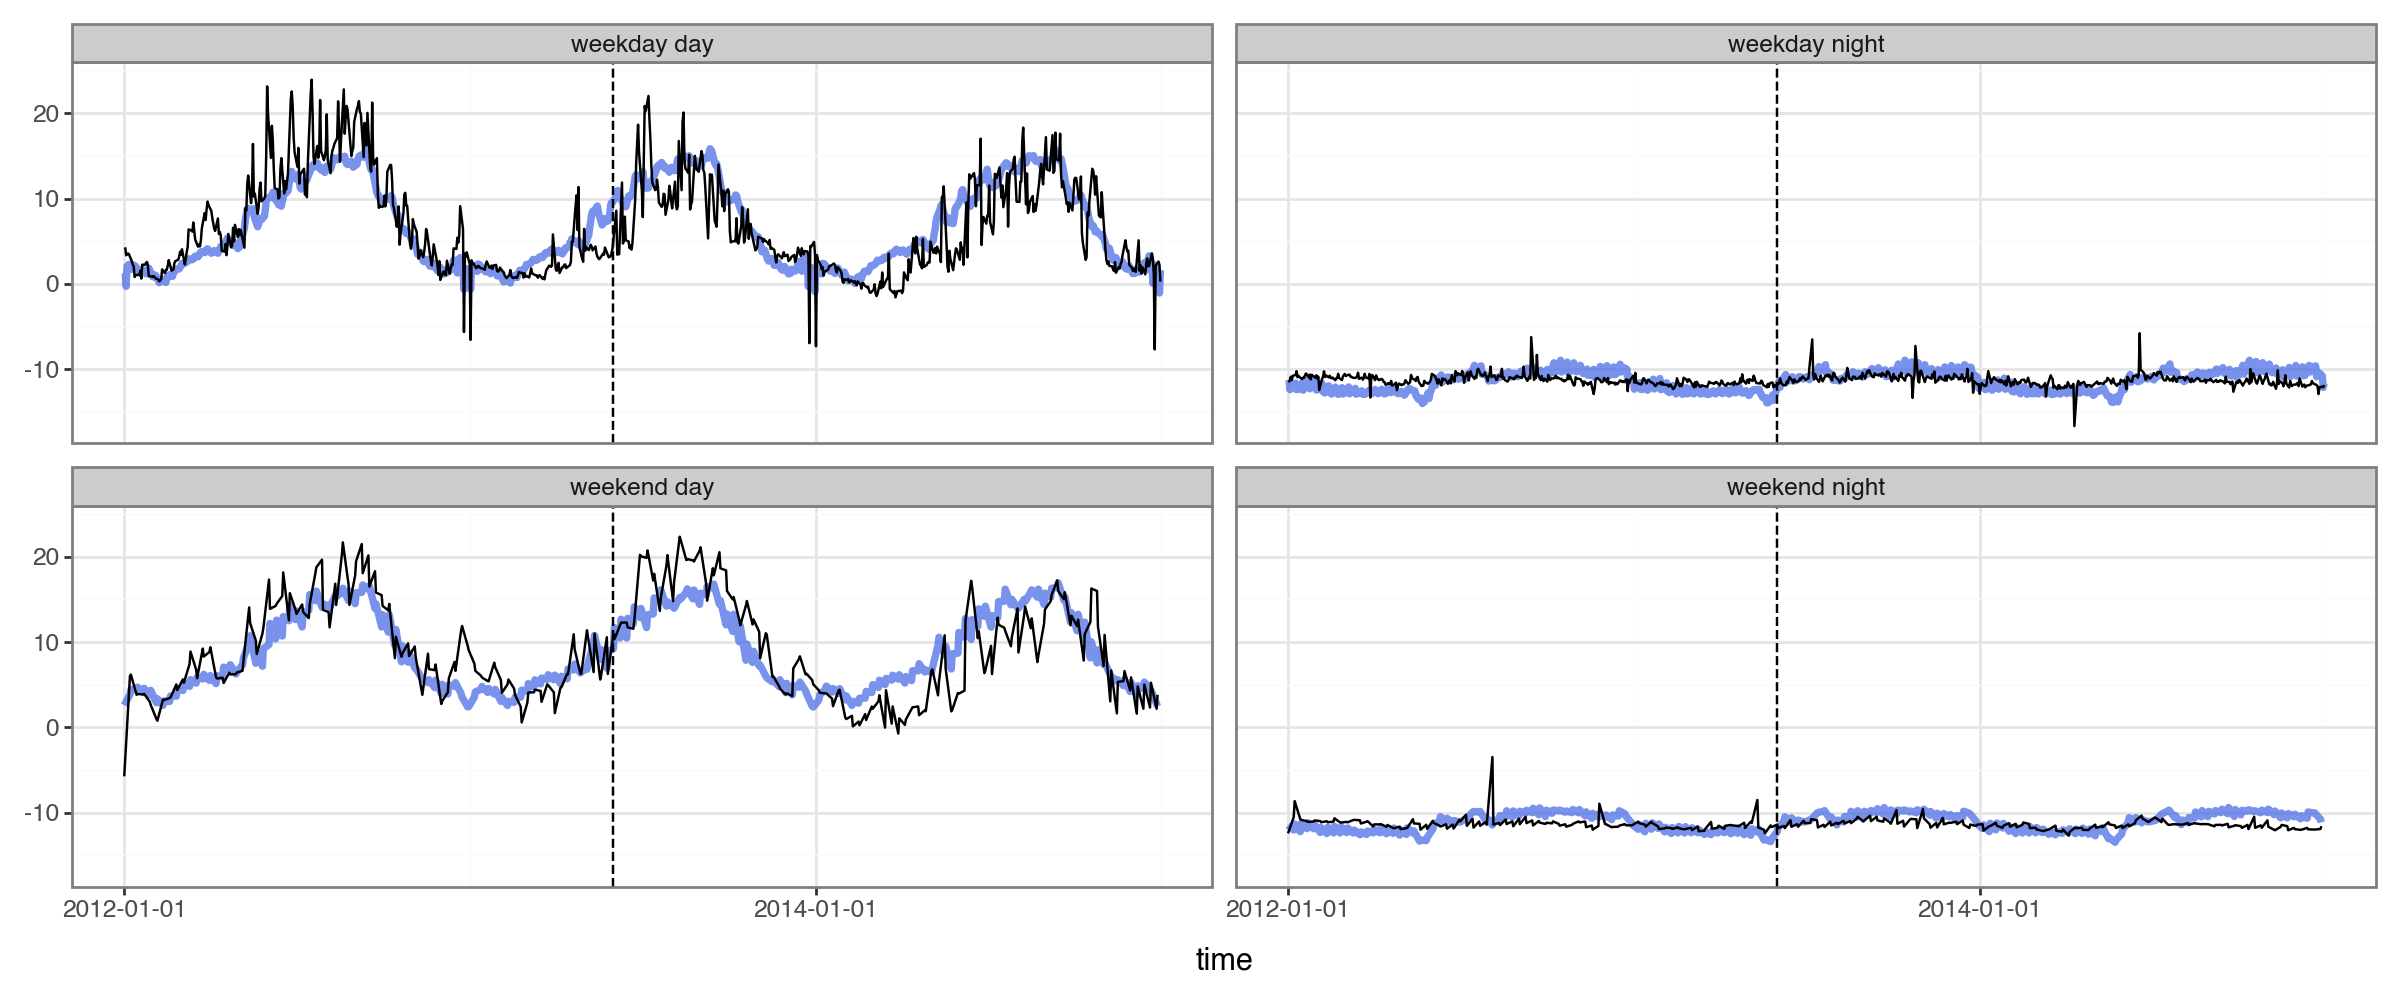

In [28]:
with torch.no_grad():
    display(ds_example_building
             .to_dataframe()
             .assign(pred=season_trainer.predict(ds_example_building).squeeze())
             .pipe(plot_2x2, actual_colname='kW_sqrt_c', pred_colname='pred', split_dt=SPLIT_DT))

Success! We now have different seasonal patterns depending on the time of the day.

### Step 2: Incorporate our Seasonal-Embeddings into our Time-Series Model

How should we incorporate our `season_embedder` neural-network into a state-space model? First, we create our time-series model:

In [29]:
from torchcast.kalman_filter import KalmanFilter
from torchcast.process import LinearModel, LocalLevel

kf_nn = KalmanFilter(
    measures=['kW_sqrt_c'],
    processes=[
        LinearModel(id='nn_output', predictors=[f'nn{i}' for i in range(SEASON_EMBED_NDIM)]),
        LocalLevel(id='level'),
    ],
).to(DEVICE)

Then, we have two options:

1. The first option is to create our fourier-features on the dataframe, and pass these as features into a dataloader.

In [30]:
dataloader_kf_nn = TimeSeriesDataLoader.from_dataframe(
    df_elec
        .query("dataset=='train'")
        .pipe(add_season_features, K=8, period='yearly')
        .pipe(add_season_features, K=3, period='weekly')
        .pipe(add_season_features, K=8, period='daily')
    ,
    group_colname='subgroup',
    time_colname='time',
    dt_unit='h',
    y_colnames=['kW_sqrt_c'],
    X_colnames=season_feats,
    batch_size=50
)

...then we'd train our model with a tool like Pytorch Lightning. Torchcast also includes a simple tool for this, the `StateSpaceTrainer`:

In [31]:
from torchcast.utils.training import StateSpaceTrainer

ss_trainer = StateSpaceTrainer(
    module=kf_nn,
    dataset_to_kwargs=lambda batch: {'X' : season_trainer.module(batch.tensors[1])},
)

## commented out since we're going with option 2 below
# for loss in ss_trainer(dataloader_kf_nn):
#     print(loss)
#     # etc...

2. An even simpler (though less general) option is just to leverage the util methods in the `SeasonalEmbeddingsTrainer`, which handles converting a `TimeSeriesDataset` into a tensor of fourier terms:

In [32]:
def dataset_to_kwargs(batch: TimeSeriesDataset) -> dict:
    seasonX = season_trainer.times_to_model_mat(batch.times()).to(dtype=torch.float, device=DEVICE)
    return {'X' : season_trainer.module(seasonX)}

ss_trainer = StateSpaceTrainer(
    module=kf_nn,
    dataset_to_kwargs=dataset_to_kwargs,
    optimizer=torch.optim.Adam(kf_nn.parameters(), lr=.05)
)

Then we don't need to use `add_season_features` when creating our data-loader, since `season_trainer.times_to_model_mat` will create them per-batch as needed (which will be much easier on our GPU's memory):

In [33]:
dataloader_kf_nn = TimeSeriesDataLoader.from_dataframe(
    df_elec.query("dataset=='train'"),
    group_colname='group',
    time_colname='time',
    dt_unit='h',
    measure_colnames=['kW_sqrt_c'],
    batch_size=40
)

<div class="admonition note">
<div class="admonition-title">Training End-to-End</div>

Above, we never actually registered ``season_trainer.module`` as an attribute of our KalmanFilter (i.e. we didn't do
``kf_nn.season_nn = season_trainer.module``). This means that we won't continue training the embeddings as we train our KalmanFilter.
Why not? For that matter, why did we pre-train in the first place? Couldn't we have just registered an untrained embeddings network
and trained the whole thing end to end?

In practice, neural-networks have many more parameters and take many more epochs than our state-space models (and conversely, our
state-space models are much slower to train _per_ epoch). So it's much more efficient to pre-train the network first. Then it's up to
us whether we want to continue training the network, or just freeze its weights (i.e. exclude it from the optimizer) and just train the
state-space models' parameters. Here we're freezing them by not assigning the network as an attribute (so that the parameters don't get
passed to when we run ``torch.optim.Adam(kf_nn.parameters(), lr=.05)``).

</div>

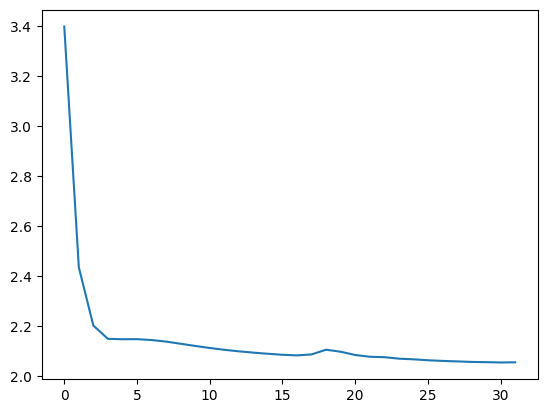

In [34]:
try:
    _path = os.path.join(BASE_DIR, f"ss_trainer{SEASON_EMBED_NDIM}.pt")
    with open(_path, 'rb') as f:
        ss_trainer = pickle.load(f).to(DEVICE)
    kf_nn = ss_trainer.module
    plt.plot(ss_trainer.loss_history)
    plt.show()
except FileNotFoundError as e:
    torch.cuda.empty_cache()
    ss_trainer.loss_history = []
    for loss in ss_trainer(dataloader_kf_nn, forward_kwargs={'n_step' : 14*7*24, 'every_step' : False}):
        ss_trainer.loss_history.append(loss)
        print(loss)

        with open(_path, 'wb') as f:
            pickle.dump(ss_trainer, f)

        if len(ss_trainer.loss_history) > 30:
            break

Now we'll create forecasts for all the groups, and back-transform them, for plotting and evaluation.

In [35]:
with torch.inference_mode():
    dataloader_all = TimeSeriesDataLoader.from_dataframe(
        # importantly, we'll set to `nan` our target when it's outside the training dates
        # this allows us to use `season_feats` in the forecast period, while not having data-leakage
        df_elec.assign(kW_sqrt_c=lambda df: df['kW_sqrt_c'].where(df['dataset']=='train')), 
        group_colname='group',
        time_colname='time',
        dt_unit='h',
        measure_colnames=['kW_sqrt_c'],
        batch_size=50
    )

    df_all_preds = []
    for batch in tqdm(dataloader_all):
        batch = batch.to(DEVICE)
        seasonX = season_trainer.times_to_model_mat(batch.times()).to(dtype=torch.float, device=DEVICE)
        pred = kf_nn(batch.tensors[0], X=season_trainer.module(seasonX), start_offsets=batch.start_offsets)
        df_all_preds.append(pred.to_dataframe(batch).drop(columns=['actual']))
df_all_preds = pd.concat(df_all_preds).reset_index(drop=True)
# back-transform:
df_all_preds = (df_all_preds
                 .merge(df_elec[['group','time','kW','dataset']])
                 .pipe(add_inv_transformed))
df_all_preds

  0%|          | 0/7 [00:00<?, ?it/s]

group                time measure        mean       lower  \
0        MT_001 2012-01-01 00:00:00      kW    1.082254    0.000000   
1        MT_001 2012-01-01 01:00:00      kW    0.310771    0.000000   
2        MT_001 2012-01-01 02:00:00      kW    1.107223    0.000000   
3        MT_001 2012-01-01 03:00:00      kW    2.929986    0.000000   
4        MT_001 2012-01-01 04:00:00      kW    3.193181    0.000000   
...         ...                 ...     ...         ...         ...   
9548093  MT_369 2014-12-31 19:00:00      kW  837.038351  476.854138   
9548094  MT_369 2014-12-31 20:00:00      kW  827.792654  469.883535   
9548095  MT_369 2014-12-31 21:00:00      kW  825.009801  467.797983   
9548096  MT_369 2014-12-31 22:00:00      kW  836.413866  476.404624   
9548097  MT_369 2014-12-31 23:00:00      kW  834.969746  475.313702   

               upper          kW dataset  
0         133.029539    3.172589   train  
1          36.109307    4.124365   train  
2          33.909440    4.758883   train  
3          38.848475    4.441624   train  
4          37.979428    4.758883   train  
...              ...         ...     ...  
9548093  1297.889977  692.631965     val  
9548094  1286.368139  688.416422     val  
9548095  1282.881138  662.023460     val  
9548096  1297.076318  679.252199     val  
9548097  1295.279827  659.274194     val  

[9548098 rows x 8 columns]

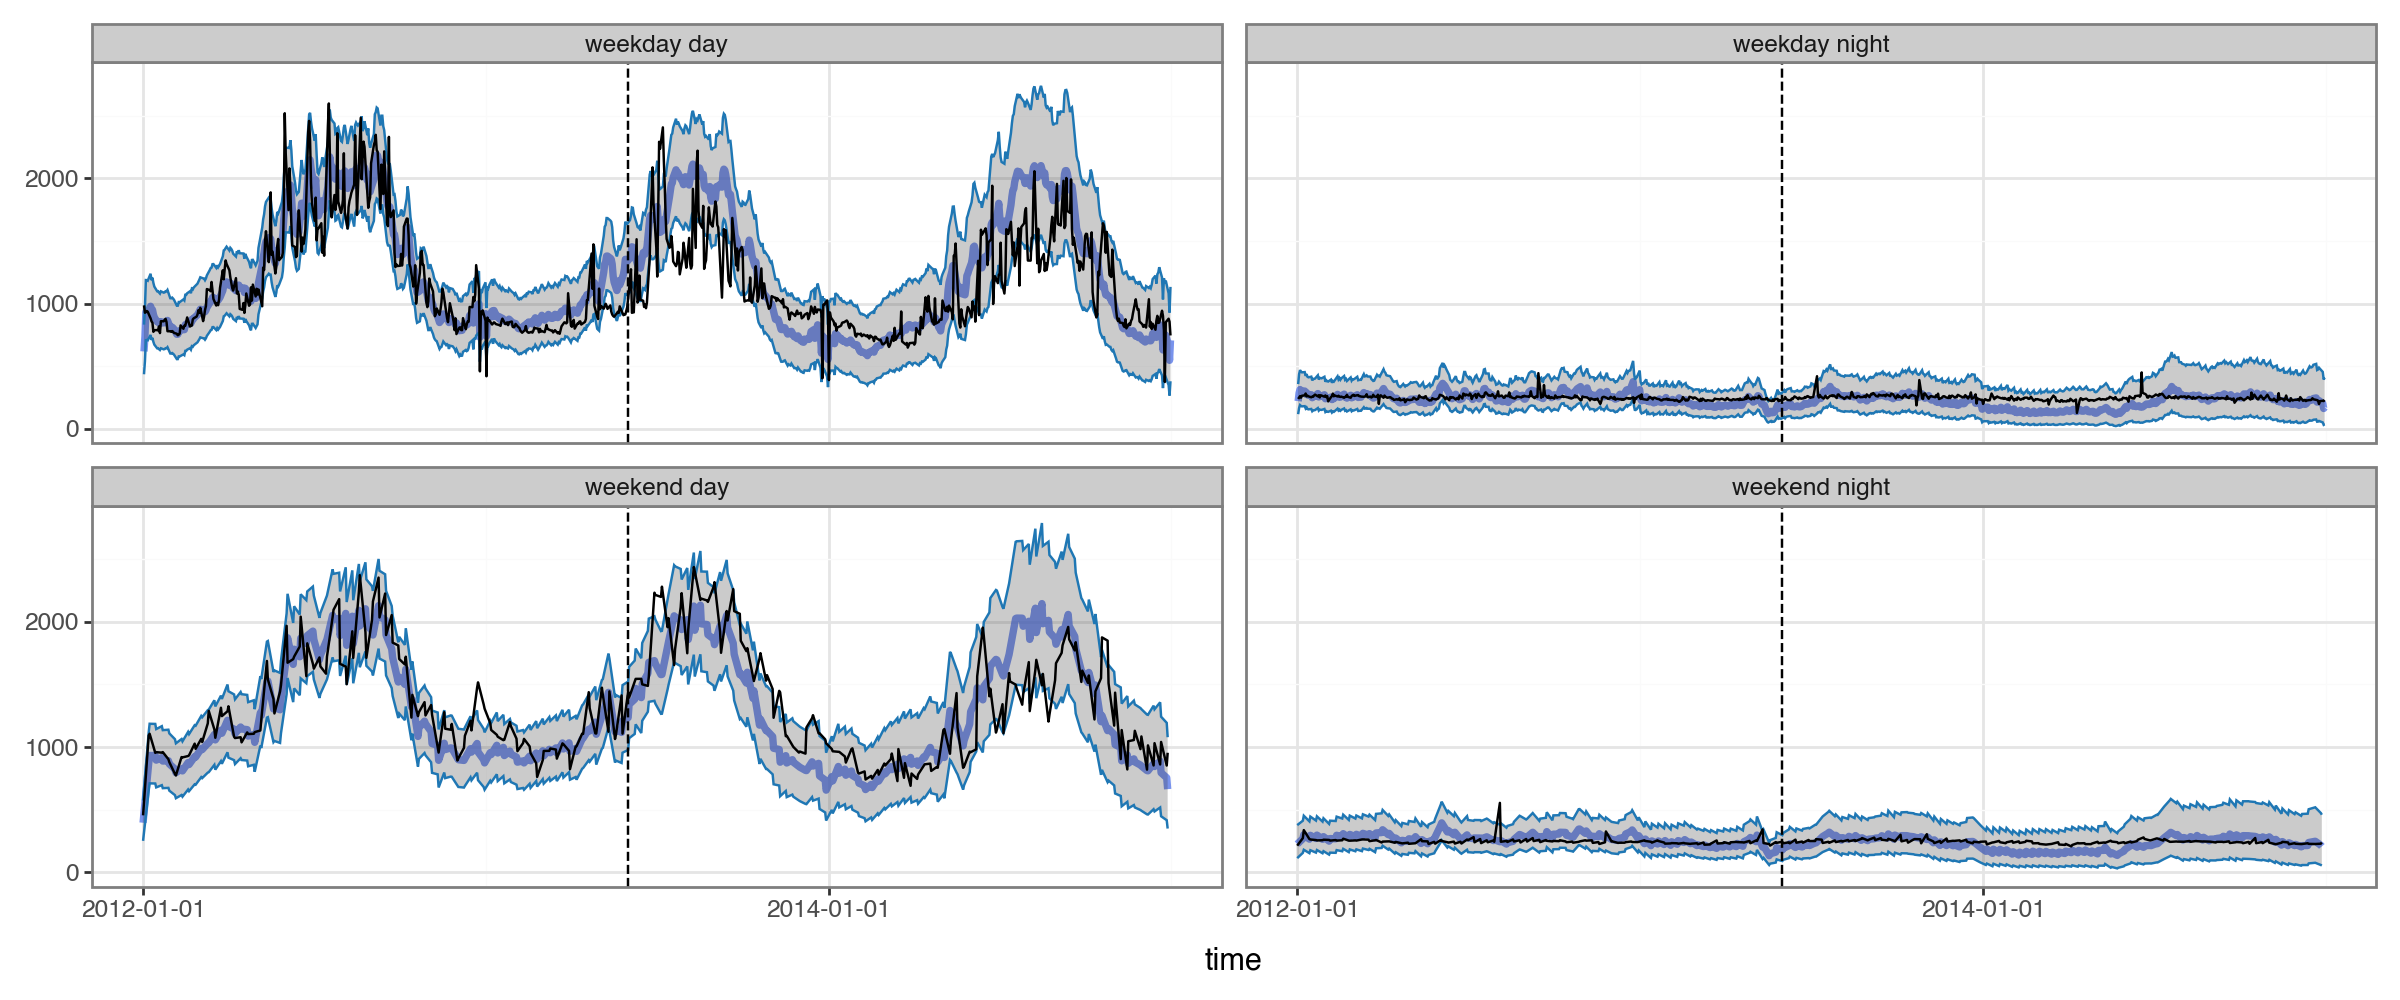

In [36]:
plot_2x2(df_all_preds.query("group==@example_group"), actual_colname='kW', split_dt=SPLIT_DT)

Success! If our example group is representative, our forecasting model was able to use the embeddings to capture complex seasonal structure.

### Evaluation

#### A Simple Baseline

We've see that, for this dataset, generating forecasts that are *sane* is already an achievement.

But of course, ideally we'd actually have some kind of a quantitative measure of how good our forecasts are.

For this, it's helpful to compare to a baseline. `torchcast` provides a simple baseline which just forecasts based on N-timesteps ago, with options for first smoothing the historical data. In this case, we forecast based on the same timepoint 365 days ago, after first applying a rolling-average with a 4-hour window.

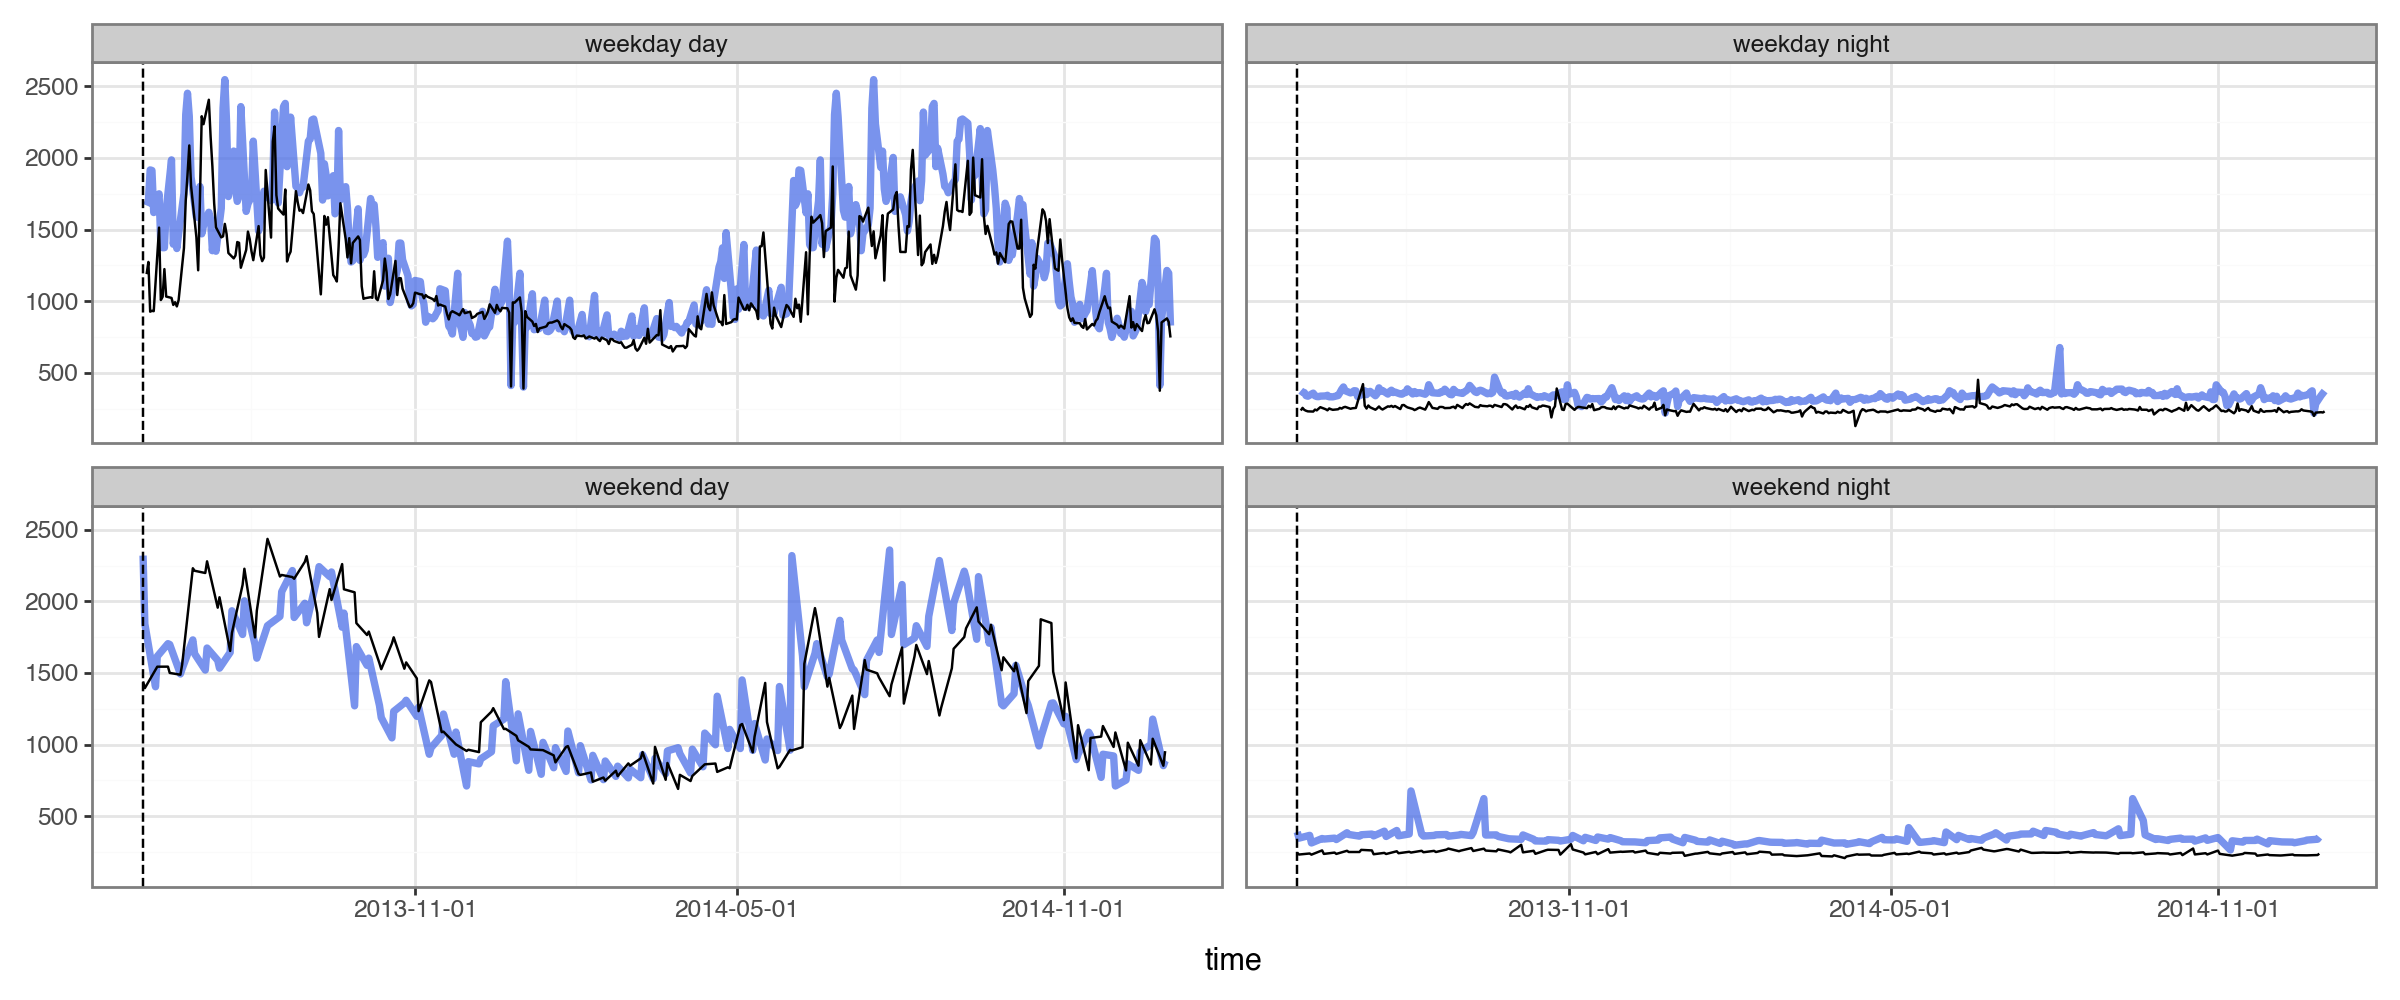

In [37]:
from torchcast.utils import make_baseline

df_baseline365 = make_baseline(df_elec,
                                group_colnames=['group'],
                                time_colname='time',
                                value_colname='kW',
                                is_train=lambda df: df['dataset']=='train',
                                lag=int(365*24), 
                                smooth=4)
plot_2x2(
    df_baseline365.query("group==@example_group").merge(df_elec), 
    pred_colname='baseline',
    actual_colname='kW', 
    split_dt=SPLIT_DT
)

We can see this baseline provides sensible enough forecasts on our example building.

#### Comparison of Performance

Now that we have something to compare our torchcast model to, we can evaluate its performance.

In [38]:
df_compare = (df_all_preds[['group', 'mean', 'time', 'kW', 'dataset']]
             .rename(columns={'mean' : 'torchcast'})
             .merge(df_baseline365, how='left'))

df_compare_long = df_compare.melt(
    id_vars=['group', 'time', 'kW', 'dataset'], 
    value_vars=['torchcast', 'baseline'], 
    var_name='model', 
    value_name='forecast'
)
df_compare_long['error'] = np.abs(df_compare_long['forecast'] - df_compare_long['kW'])
df_compare_long

group                time          kW dataset      model  \
0         MT_001 2012-01-01 00:00:00    3.172589   train  torchcast   
1         MT_001 2012-01-01 01:00:00    4.124365   train  torchcast   
2         MT_001 2012-01-01 02:00:00    4.758883   train  torchcast   
3         MT_001 2012-01-01 03:00:00    4.441624   train  torchcast   
4         MT_001 2012-01-01 04:00:00    4.758883   train  torchcast   
...          ...                 ...         ...     ...        ...   
19096191  MT_369 2014-12-31 19:00:00  692.631965     val   baseline   
19096192  MT_369 2014-12-31 20:00:00  688.416422     val   baseline   
19096193  MT_369 2014-12-31 21:00:00  662.023460     val   baseline   
19096194  MT_369 2014-12-31 22:00:00  679.252199     val   baseline   
19096195  MT_369 2014-12-31 23:00:00  659.274194     val   baseline   

            forecast      error  
0           1.082254   2.090335  
1           0.310771   3.813595  
2           1.107223   3.651660  
3           2.929986   1.511639  
4           3.193181   1.565702  
...              ...        ...  
19096191  712.793255  20.161290  
19096192  702.025293  13.608871  
19096193  708.486070  46.462610  
19096194  728.464076  49.211877  
19096195  751.282991  92.008798  

[19096196 rows x 7 columns]

**Over Time**

First let's compare abs(error) over time, across all groups:

<Axes: title={'center': 'Torchcast vs. Baseline: Error over Time'}, xlabel='date', ylabel='Abs(Error)'>

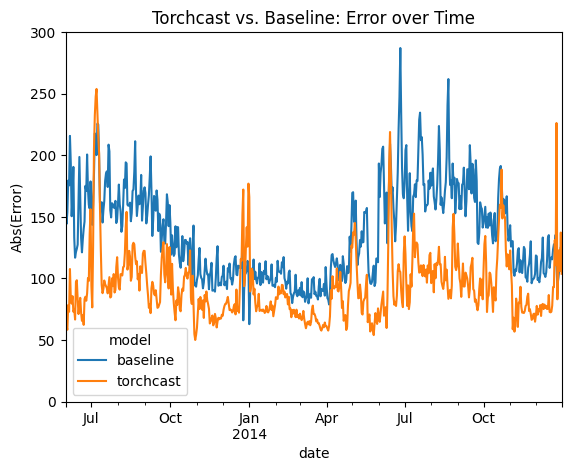

In [39]:
df_compare_per_date = (df_compare_long
                       .query("dataset!='train'")
                       .assign(date=lambda df: df['time'].dt.normalize())
                       .groupby(['date', 'model'])
                       ['error'].mean()
                       .reset_index())
(df_compare_per_date
 .pivot(index='date', columns='model', values='error')
 .plot(ylim=(0, 300), ylabel="Abs(Error)", title="Torchcast vs. Baseline: Error over Time"))

We can see that the torchcast model beats the baseline *almost* ever day. The clear exception is holidays (e.g. Thanksgiving and Christmas), which makes sense: we didn't add any features for these to our torchcast model, while the baseline model essentially gets these for free. Future attempts could resolve this straightforwardly by adding dummy-features to our `LinearModel`, or by increasing the `K` (aka "wiggliness") parameter (see _"Encoding Seasonlity as Fourier Terms"_ above).

**By Group**

Now let's compare over the whole test period, focusing on _percent_ error (relative to that group's average) so that we can weight small and large groups equally.

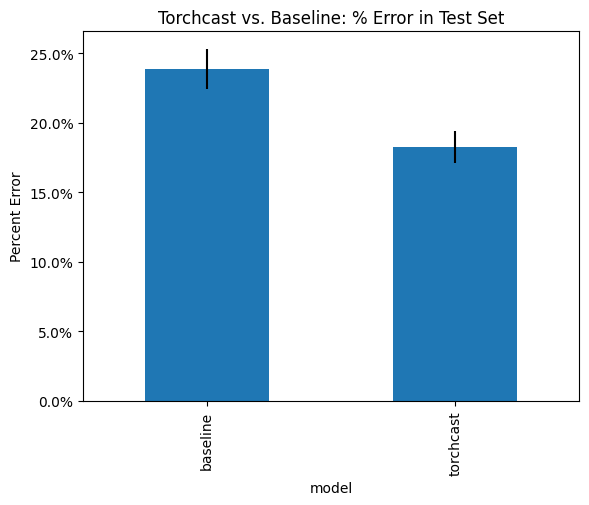

In [40]:
from matplotlib.ticker import PercentFormatter

df_compare_per_group = (df_compare_long
                         .groupby(['group', 'dataset', 'model'])
                         [['error', 'kW']].mean()
                         .reset_index()
                         .assign(prop_error=lambda df: df['error'] / df['kW']))

compare_per_group_agg = (df_compare_per_group
                         .groupby(['dataset', 'model'])
                         .agg(prop_error=('prop_error', 'mean'), sem=('prop_error', 'sem')))

(compare_per_group_agg.loc['test']['prop_error']
 .plot(kind='bar', 
       yerr=compare_per_group_agg.loc['test']['sem'], 
       ylabel='Percent Error', 
       title="Torchcast vs. Baseline: % Error in Test Set")
 .yaxis.set_major_formatter(PercentFormatter(xmax=1)))

We see that the torchcast forecasts have significantly lower % error on average.